# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions, plot_samples
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.experimental.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
import torch

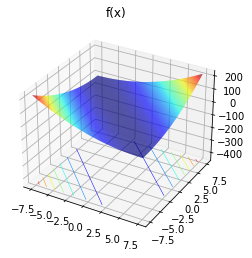

In [3]:
# setup expectation function
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Let's start with Guassian Problem


Shows basic flow model is working (IAF clearly very expressive), if we use a friendly gaussian relatively well suited to the pior <br>
We see here that KL and DReG get very similar results

## Setup

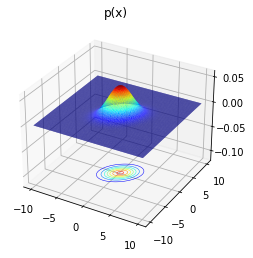

In [4]:
torch.manual_seed(2)
epochs = 1000
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim, scale_covariance=1)
fig = plot_distribution(target)

In [5]:
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
true_expectation

tensor(8.2108)

## Flow with DReG - well suited prior

In [6]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, prior_scaling=1, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

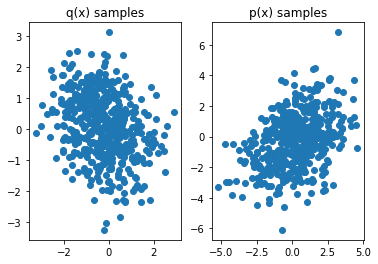

In [7]:
samples_fig_before = plot_samples(tester)

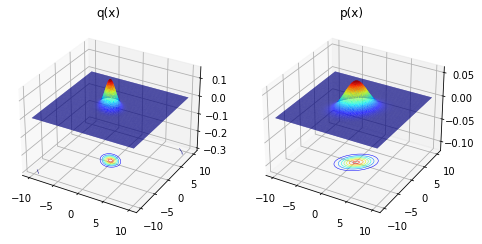

In [8]:
fig_before_train = plot_distributions(tester)

In [9]:
history = tester.train(epochs, batch_size=1000)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: 1.0986745357513428, mean log p_x -3.510347366333008: 100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.30it/s]

estimate before training is 6.897197246551514 
estimate after training is 8.902179718017578 
effective sample size is 7092.5517578125 
variance in weights is 4.099715678052007e-09


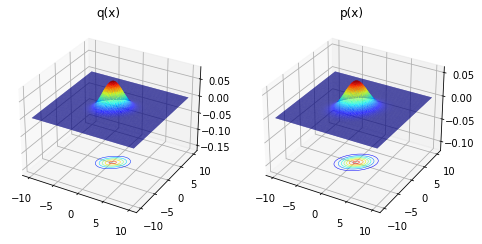

In [10]:
fig_after_train = plot_distributions(tester)

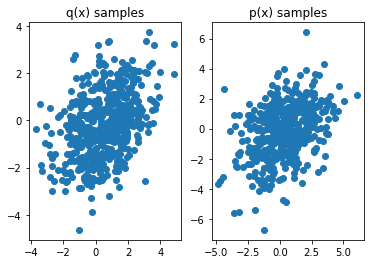

In [11]:
samples_fig_after = plot_samples(tester)

NaN encountered in loss history
NaN encountered in log_p_x history
NaN encountered in log_q_x history


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

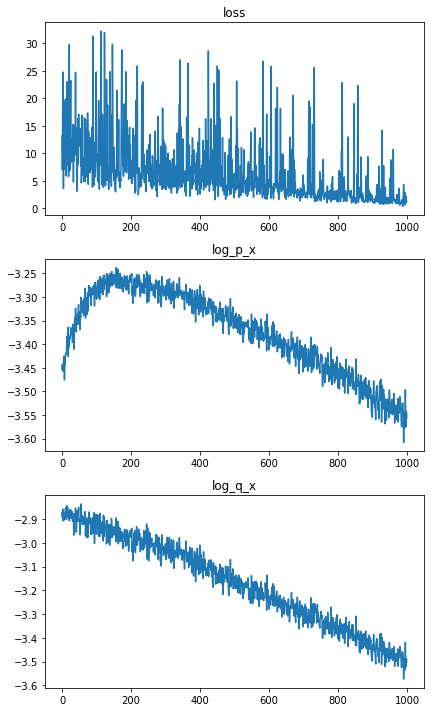

In [12]:
plot_history(history)

## Flow with KL - nice prior

In [24]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

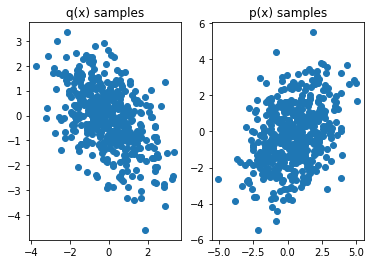

In [25]:
samples_fig_before = plot_samples(tester)

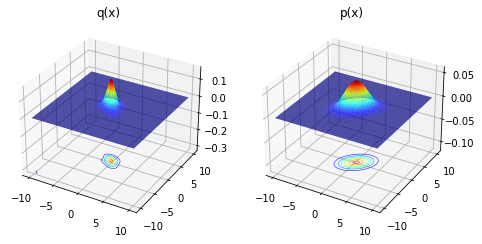

In [26]:
fig_before_train = plot_distributions(tester)

In [27]:
history = tester.train(epochs, batch_size=100)
#expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)


print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")


loss: 0.004051997791975737, mean log p_x -3.9025704860687256: 100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.94it/s]

estimate before training is 8.729157447814941 
estimate after training is 8.902179718017578 
effective sample size is 7092.5517578125 
variance in weights is 4.099715678052007e-09


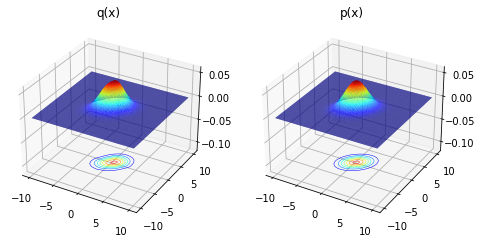

In [28]:
fig_after_train = plot_distributions(tester)

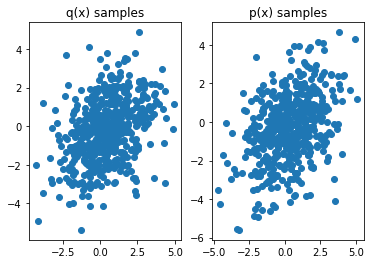

In [29]:
samples_fig_after = plot_samples(tester)

NaN encountered in loss history
NaN encountered in log_p_x history
NaN encountered in log_q_x history


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

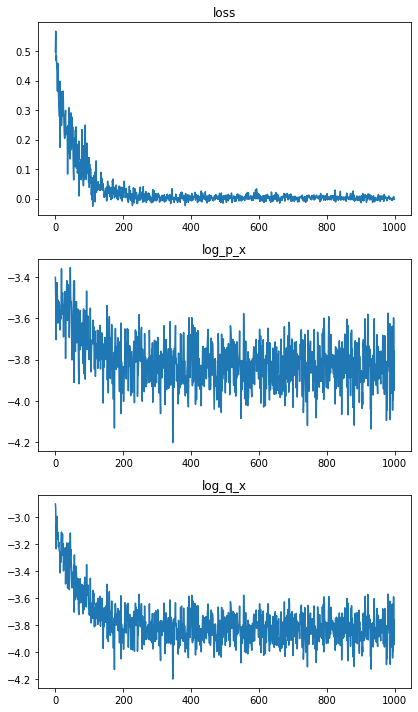

In [30]:
plot_history(history)

## Setup nastier prior

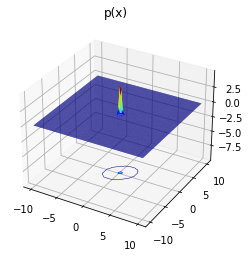

In [45]:
torch.manual_seed(2)
epochs = 1000
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim, scale_covariance=0.01)
fig = plot_distribution(target)

## Flow with DReG - poorly suited prior

Hypothesis for poor performance
<br>
We see that it does badly, and that the loss decreases by decreasing p(x) and increasing q(x). The spikes in the loss function seen in the history correspond to sampling the unlikely, but very high p(x) and low q(x) that would correspond to big penalty in the integral (but as q(x) gets steeper, these become less likely to be sampled from. 

In [58]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, prior_scaling=1)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
#expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

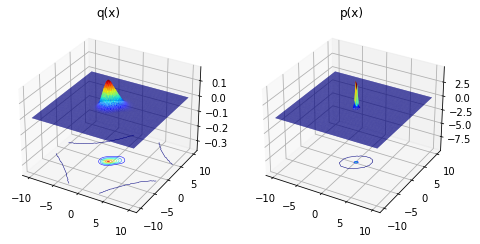

In [59]:
fig_before_train = plot_distributions(tester)

In [60]:
history = tester.train(10000, batch_size=100) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: 0.019022518768906593, mean log p_x 0.7954937219619751: 100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 103.64it/s]

effective sample size is 9914.150390625 
variance in weights is 8.660053230080678e-11


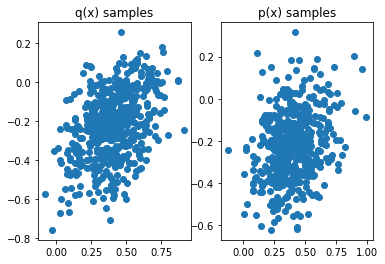

In [61]:
samples_fig_after = plot_samples(tester)

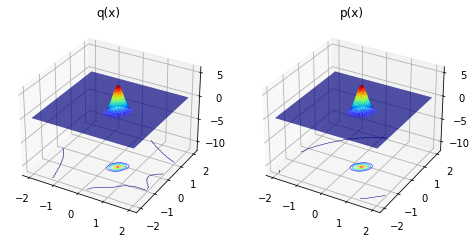

In [62]:
fig_after_train = plot_distributions(tester, bounds = [[-2, 2],[-2, 2]])

NaN encountered in loss history
NaN encountered in log_p_x history
NaN encountered in log_q_x history


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

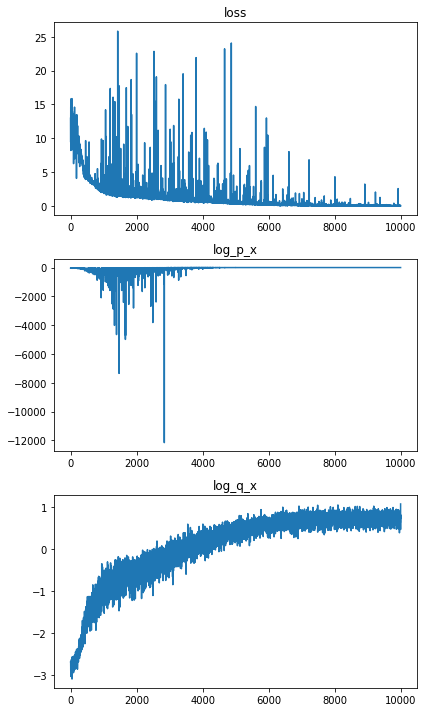

In [63]:
plot_history(history)

## Flow with kl - poorly suited prior

In [73]:
torch.manual_seed(2) # if we set this to 1 it is happy
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

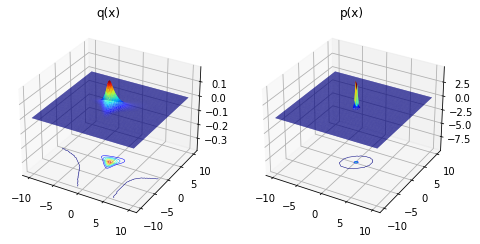

In [74]:
dist_before = plot_distributions(tester)
# below plot if we want to look in specific zone
#flow_only = plot_distribution(tester.learnt_sampling_dist, bounds = [[-100, 0],[-10, 10]], n_points=200)

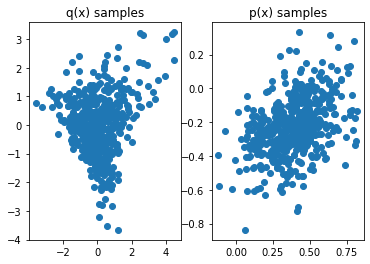

In [75]:
samples_fig_before = plot_samples(tester)

In [76]:
history = tester.train(10000, batch_size=100)

expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")


loss: 0.005476100370287895, mean log p_x 0.6479987502098083: 100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 103.83it/s]

effective sample size is 9950.5400390625 
variance in weights is 4.9715974392849915e-11


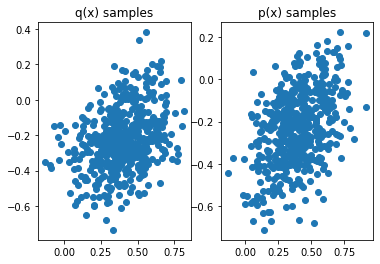

In [77]:
samples_fig_after = plot_samples(tester)

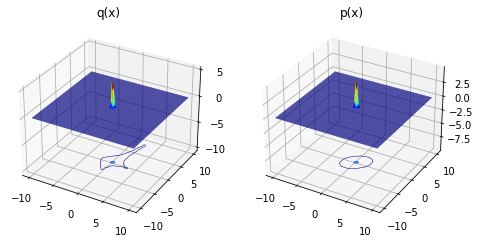

In [78]:
fig_after_train = plot_distributions(tester)

NaN encountered in loss history
NaN encountered in log_p_x history
NaN encountered in log_q_x history


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

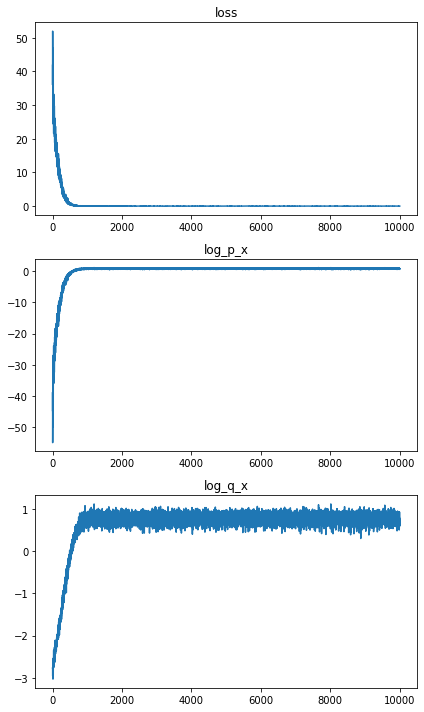

In [79]:
plot_history(history)

## AIS train
This does seem to help if we use enough updates and intermediate distributions

In [71]:
learnt_sampler = FlowModel(x_dim=dim) #, flow_type="RealNVP")
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=4, n_updates_Metropolis=20)

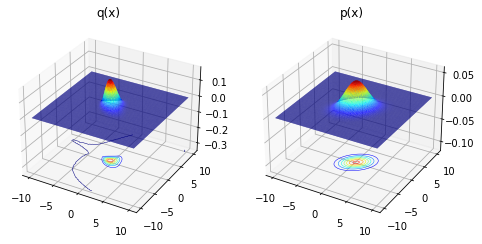

In [72]:
fig = plot_distributions(tester)

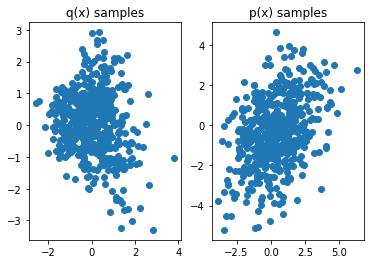

In [73]:
samples_fig_before = plot_samples(tester)

In [ ]:
history = tester.train(500, batch_size=200)

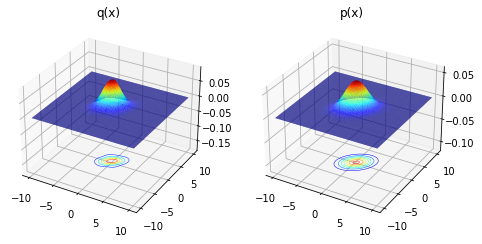

In [69]:
fig = plot_distributions(tester)

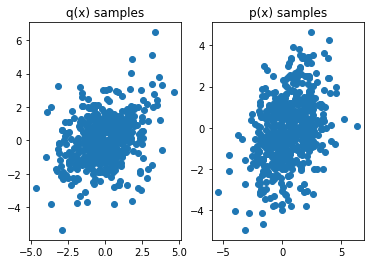

In [70]:
samples_fig_before = plot_samples(tester)

NaN encountered in loss history


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

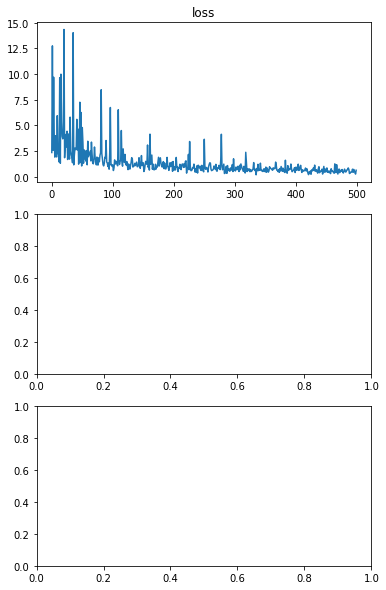

In [66]:
plot_history(history)

In [67]:
len(info['normalised_sampling_weights'])

10000

In [68]:
tester.importance_sampler = VanillaImportanceSampling # to make comparison fair with previous models use this for expectation estimation
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

effective sample size is 7202.31103515625 
variance in weights is 3.884811583532155e-09


## Let's compare to our standard diagonal guassian case to show that flows help

In [ ]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation()

In [ ]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation)
true_expectation = torch.sum(tester.target_dist.mean)

print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

# Now let's do some MoG

doesn't work well (for both DReG and KL)

## Setup

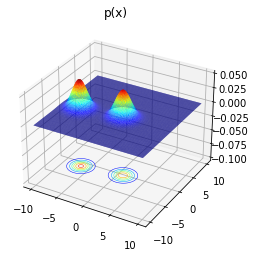

In [4]:
torch.manual_seed(2)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=2, min_cov=1)
fig = plot_distribution(target)

## DReG

In [127]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=5) #  , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG") # "kl"

In [128]:
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

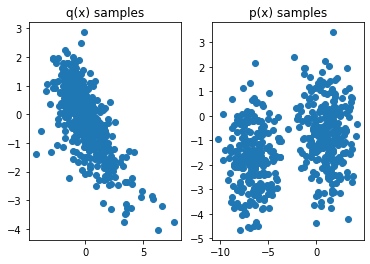

In [129]:
samples_before = plot_samples(tester)

In [130]:
#fig_before_train = plot_distributions(tester)

In [131]:
history = tester.train(10000, batch_size=500)

loss: -1.2907744646072388, mean log p_x -4.03329610824585: 100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:20<00:00, 38.32it/s]


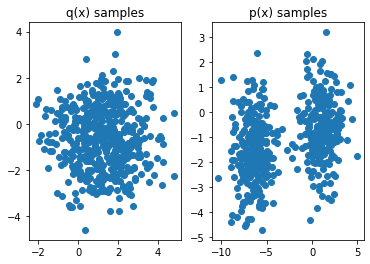

In [132]:
samples_fig_after = plot_samples(tester)

In [133]:
#fig_after_train = plot_distributions(tester)

In [134]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 51.248870849609375 
estimate after training is 3.7548575401306152 
effective sample size is 6444.87548828125 
variance in weights is 5.516759937762572e-09


NaN encountered in loss history
NaN encountered in log_p_x history
NaN encountered in log_q_x history


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

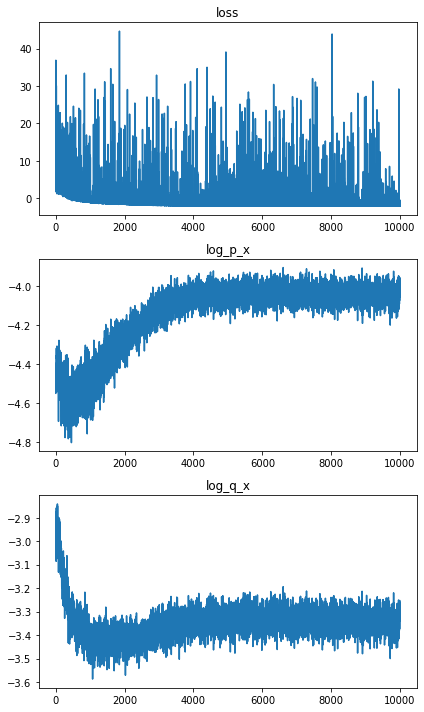

In [135]:
plot_history(history)

## kl
Focuses on minimising q(x), by making q(x) very wide (which decreases the loss by decreasing faster than p(x)
<br>
If we use a minimum threshold for log q(x) then we prevent this behavior

In [120]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

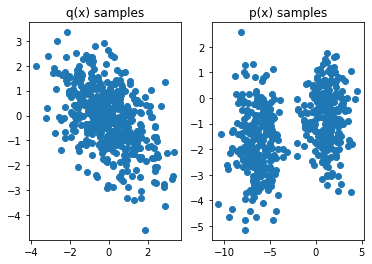

In [121]:
samples_before = plot_samples(tester)

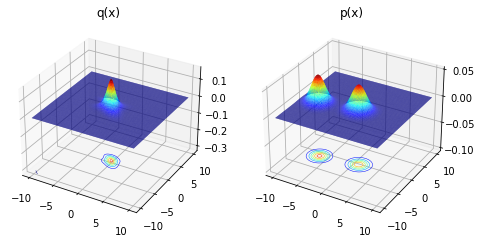

In [122]:
fig_before_train = plot_distributions(tester)

In [123]:
history = tester.train(500, batch_size=100) # epochs

loss: 0.596966564655304, mean log p_x -4.707481861114502:  95%|██████████████████████████████████████████████████████████████████████████████████    | 477/500 [00:04<00:00, 98.21it/s]

found a NaN and overwrote it during flow gradient calculation
found a NaN and overwrote it during flow gradient calculation
found a NaN and overwrote it during flow gradient calculation


loss: 0.596966564655304, mean log p_x -4.707481861114502: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.26it/s]


In [124]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 32.91842269897461 
estimate after training is nan 
effective sample size is 1.0 
variance in weights is 9.999999747378752e-05


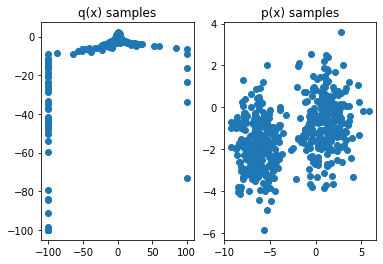

In [125]:
samples_after = plot_samples(tester)

NaN encountered in loss history
NaN encountered in log_p_x history
NaN encountered in log_q_x history


(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

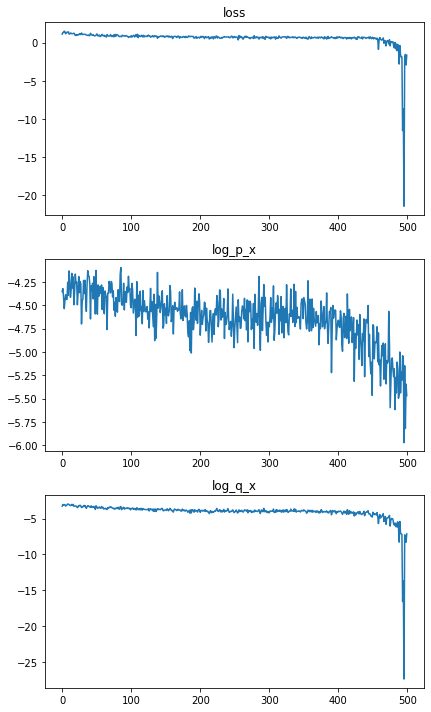

In [126]:
plot_history(history)

## AIS + DreG

In [47]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=5) #, flow_type="RealNVP")
#tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=3, n_updates_Metropolis=20)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=3, n_updates_Metropolis=5)

In [ ]:
samples_before = plot_samples(tester)

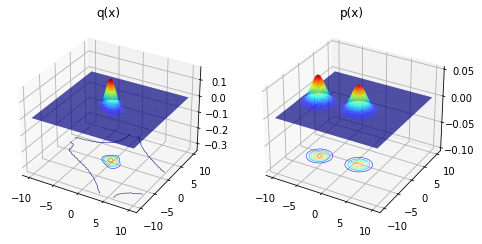

In [48]:
fig_before = plot_distributions(tester)

In [49]:
history = tester.train(200, batch_size=500)

loss: 18.591100692749023, mean log p_x -4.297166347503662: 100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.35it/s]


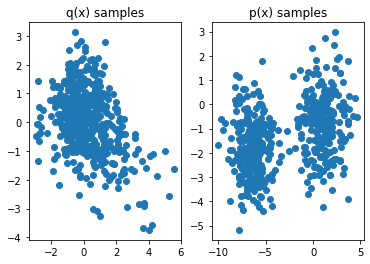

In [50]:
samples_after = plot_samples(tester)

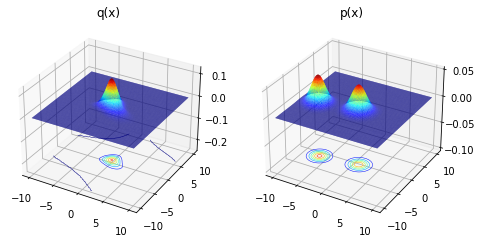

In [51]:
fig = plot_distributions(tester)

In [ ]:
history = tester.train(1000, batch_size=400)

In [ ]:
fig = plot_distributions(tester, range=10)

In [ ]:
plot_history(history)

# More Experiments

## Let's add extra noise to x
my hypothesis is that this should help
 - the result is that it prevents the distribution from collapsing, but the distribution still struggles (I suppose adding noise also breaks the objective function, as expectation no longer over q(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from FittedModels.Models.base import BaseLearntDistribution
Notebook = True
if Notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

class LearntDistributionManager:
    def __init__(self, target_distribution, fitted_model, importance_sampler,
                 loss_type="kl", alpha=2):
        self.importance_sampler = importance_sampler
        self.learnt_sampling_dist: BaseLearntDistribution
        self.learnt_sampling_dist = fitted_model
        self.target_dist = target_distribution
        self.optimizer = torch.optim.Adam(self.learnt_sampling_dist.parameters(), lr=1e-3)
        self.loss_type = loss_type
        self.noise_scaling_factor = 1
        if loss_type == "kl":
            self.loss = self.KL_loss
            self.alpha = 1
        elif loss_type == "DReG":
            self.loss = self.dreg_alpha_divergence_loss
            self.alpha = alpha  # alpha for alpha-divergence
            self.alpha_one_minus_alpha_sign = torch.sign(torch.tensor(self.alpha * (1 - self.alpha)))
        else:
            raise Exception("loss_type incorrectly specified")


    def train(self, epochs=100, batch_size=256, samples_per_epoch=1000):
        epoch_per_print = max(int(epochs / 10), 1)
        history = {"loss": [],
                   "log_p_x": [],
                   "log_q_x": []}
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            self.optimizer.zero_grad()
            x_samples, log_q_x = self.learnt_sampling_dist(batch_size)
            x_samples = x_samples + torch.randn(x_samples.shape)*self.noise_scaling_factor
            log_q_x = self.learnt_sampling_dist.log_prob(x_samples)
            log_p_x = self.target_dist.log_prob(x_samples)
            loss = self.loss(log_q_x, log_p_x)
            if True in torch.isnan(log_p_x) or True in torch.isinf(loss):
                print("NaN/-inf loss encountered in log_p_x")
            if True in torch.isnan(log_q_x) or True in torch.isinf(log_q_x):
                print("NaN/-inf loss encountered in log_q_x")
            if torch.isnan(loss) or torch.isinf(loss):
                from FittedModels.utils import plot_history
                import matplotlib.pyplot as plt
                plot_history(history)
                plt.show()
                raise Exception(f"NaN loss encountered on epoch {epoch}")
            loss.backward()
            self.optimizer.step()
            history["loss"].append(loss.item())
            history["log_p_x"].append(torch.mean(log_p_x))
            history["log_q_x"].append(torch.mean(log_q_x))
            if epoch % epoch_per_print == 0 or epoch == epochs:
                pbar.set_description(f"loss: {history['loss'][-1]}, mean log p_x {torch.mean(log_p_x)}")
        return history

    def KL_loss(self, log_q_x, log_p_x):
        kl = log_q_x - log_p_x
        # prevent -inf from low density regions breaking things
        kl = torch.masked_select(kl, ~torch.isinf(kl) & ~torch.isnan(kl))
        return torch.mean(kl)

    def dreg_alpha_divergence_loss(self, log_q_x, log_p_x):
        # summing all samples within the log
        log_w = log_p_x - log_q_x
        # prevent -inf from low density regions breaking things
        log_w = torch.masked_select(log_w, ~torch.isinf(log_w) & ~torch.isnan(log_w))
        with torch.no_grad():
            w_alpha_normalised_alpha = F.softmax(self.alpha*log_w, dim=-1)
        return torch.sum(((1 + self.alpha) * w_alpha_normalised_alpha + self.alpha * w_alpha_normalised_alpha**2) * log_w)

    @torch.no_grad()
    def estimate_expectation(self, n_samples=int(1e4), expectation_function=lambda x: torch.sum(x, dim=-1)):
        importance_sampler = self.importance_sampler(self.learnt_sampling_dist, self.target_dist)
        expectation, normalised_sampling_weights = importance_sampler.calculate_expectation(n_samples, expectation_function)
        return expectation, normalised_sampling_weights

    def effective_sample_size(self, normalised_sampling_weights):
        return self.importance_sampler.effective_sample_size(normalised_sampling_weights)


In [ ]:
torch.manual_seed(2)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=2, min_cov=1)

In [ ]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #  , flow_type="RealNVP"
learnt_sampler.prior = torch.distributions.MultivariateNormal(loc=torch.zeros(dim),
                                                            covariance_matrix=torch.eye(dim)*20)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG") # "kl"

expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
fig_before_train = plot_distributions(tester, range=20)

In [ ]:
history = tester.train(epochs=500, batch_size=100)

In [ ]:
fig_after_train = plot_distributions(tester, range=20)

In [ ]:
plot_history(history)

# New Section